## Skeleton Code

The code below provides a skeleton for the model building & training component of your project. You can add/remove/build on code however you see fit, this is meant as a starting point.

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

##Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.
import itertools
from sklearn.model_selection import train_test_split
from random import sample 
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
from keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, Model

from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix


Using TensorFlow backend.


In [2]:
import tensorflow as tf
tf.version.VERSION

'2.1.0'

In [3]:
from numpy.random import seed 
seed(42)# keras seed fixing 
import tensorflow as tf 
tf.random.set_seed(42)# tensorflow seed fixing

## Do some early processing of your metadata for easier model training:

In [4]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
89645,00022260_003.png,No Finding,3,22260,54,F,PA,2542,2434,0.143,0.143,NaN,/data/images_010/images/00022260_003.png
47446,00012048_007.png,Infiltration|Mass|Nodule,7,12048,65,M,AP,2500,2048,0.168,0.168,NaN,/data/images_006/images/00012048_007.png
57963,00014352_005.png,No Finding,5,14352,6,M,PA,2992,2033,0.143,0.143,NaN,/data/images_007/images/00014352_005.png


In [5]:
plt.show()

In [6]:
import imageio
im = imageio.imread("/data/images_012/images/00029039_015.png")
print (im.shape)
print (im.dtype)
im

(1024, 1024)
uint8


Array([[ 0,  3,  4, ...,  4,  4,  4],
       [ 0,  3,  2, ...,  2,  2,  3],
       [ 0,  3,  2, ...,  2,  2,  3],
       ...,
       [ 0,  3,  2, ..., 35, 36, 31],
       [ 0,  4,  6, ..., 16, 16, 16],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

In [7]:
im.shape[0]

1024

In [8]:
from PIL import Image

#read the image
im = Image.open('/data/images_012/images/00029039_015.png')

#show image
im.show()

In [9]:
all_xray_df['path']

0         /data/images_001/images/00000001_000.png
1         /data/images_001/images/00000001_001.png
2         /data/images_001/images/00000001_002.png
3         /data/images_001/images/00000002_000.png
4         /data/images_001/images/00000003_000.png
                            ...                   
112115    /data/images_012/images/00030801_001.png
112116    /data/images_012/images/00030802_000.png
112117    /data/images_012/images/00030803_000.png
112118    /data/images_012/images/00030804_000.png
112119    /data/images_012/images/00030805_000.png
Name: path, Length: 112120, dtype: object

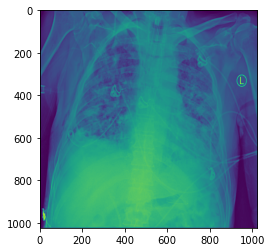

In [10]:
plt.figure()
plt.imshow(im) 
plt.show()  # display it

In [11]:
def loadImages(path):
    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        loadedImages.append(img)


In [12]:
all_xray_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 13 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
 12  path                         112120 non-null  object 
dtyp

In [13]:
all_xray_df = all_xray_df.drop(['Unnamed: 11'], axis=1)
all_xray_df.drop(all_xray_df[all_xray_df['Patient Age'] > 120].index, inplace=True)

In [14]:
all_labels = np.unique(list(itertools.chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')))))

In [15]:
for label in all_labels:
    if len(label)>1:
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda x: 1 if label in x else 0)

In [16]:
all_xray_df.rename(columns={'Pneumonia':'pneumonia_class'}, inplace=True)

In [17]:
all_xray_df['Pneumonia']=all_xray_df['pneumonia_class'].replace({1:'pneumonia',0:'no_pneumonia'})

In [18]:
all_xray_df.pneumonia_class.sum()

1430

In [19]:
len(all_xray_df)

112104

In [20]:
all_xray_df.tail()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,pneumonia_class,Pneumothorax,Pneumonia
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,1,0,0,0,1,0,pneumonia
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,no_pneumonia
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,no_pneumonia
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,1,0,0,0,0,no_pneumonia
112119,00030805_000.png,No Finding,0,30805,27,M,PA,2048,2500,0.171,...,0,0,0,0,1,0,0,0,0,no_pneumonia


In [21]:
len(all_xray_df['Patient ID'].unique())

30802

In [22]:
np.unique(all_xray_df['Patient Age'])

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85,
       86, 87, 88, 89, 90, 91, 92, 93, 94, 95])

In [23]:
# если удалишь то n_split in create split сделай равным 1
# train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(all_xray_df, groups=all_xray_df['Patient ID']))

In [23]:
# len(train_inds)

In [24]:
# len(test_inds)

In [25]:
# test = all_xray_df.iloc[test_inds]

In [33]:
# len(test)

22815

In [26]:
# train = all_xray_df.iloc[train_inds]

In [34]:
# len(train)

89289

In [27]:
# len(test[test['Pneumonia'] == 'no_pneumonia'])/len(test)

0.9884724961648038

In [28]:
# len(train[train['Pneumonia'] == 'no_pneumonia'])/len(train)

0.9869300809730202

## Create your training and testing data:

In [24]:
def create_splits(df):
    
    ## Either build your own or use a built-in library to split your original dataframe into two sets 
    ## that can be used for training and testing your model
    ## It's important to consider here how balanced or imbalanced you want each of those sets to be
    ## for the presence of pneumonia
    train_inds, test_inds = next(GroupShuffleSplit(test_size=.20, n_splits=2, random_state = 7).split(all_xray_df, groups=all_xray_df['Patient ID']))
    
    train_data, val_data = all_xray_df.iloc[train_inds], all_xray_df.iloc[test_inds]
    
    # correct the balance of the train_data to 50-50
    pneumonia_indx = train_data[train_data['Pneumonia']=='pneumonia'].index.tolist()
    no_pneumonia_indx = train_data[train_data['Pneumonia']=='no_pneumonia'].index.tolist()

    no_pneumonia_sample = sample(no_pneumonia_indx,len(pneumonia_indx))
    train_data = train_data.loc[pneumonia_indx + no_pneumonia_sample]
    
    # correct the balance in the validation according to the presence of pneumonia in this clinical situation
    pneumonia_indx = val_data[val_data['Pneumonia']=='pneumonia'].index.tolist()
    no_pneumonia_indx = val_data[val_data['Pneumonia']=='no_pneumonia'].index.tolist()

    no_pneumonia_sample = sample(no_pneumonia_indx, len(pneumonia_indx))
    val_data = val_data.loc[pneumonia_indx + no_pneumonia_sample]
    
    return train_data, val_data

In [25]:
train_data, val_data=create_splits(all_xray_df)

In [26]:
train_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,pneumonia_class,Pneumothorax,Pneumonia
48,00000013_010.png,Effusion|Pneumonia|Pneumothorax,10,13,60,M,AP,3056,2544,0.139,...,0,0,0,0,0,0,0,1,1,pneumonia
126,00000032_012.png,Atelectasis|Consolidation|Edema|Pneumonia,12,32,55,F,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,pneumonia
253,00000056_000.png,Nodule|Pneumonia,0,56,76,M,PA,2500,2048,0.168,...,0,0,0,0,0,1,0,1,0,pneumonia
590,00000144_001.png,Pneumonia,1,144,83,M,AP,2500,2048,0.168,...,0,0,0,0,0,0,0,1,0,pneumonia
614,00000150_002.png,Atelectasis|Infiltration|Pneumonia,2,150,55,F,AP,3056,2544,0.139,...,0,0,1,0,0,0,0,1,0,pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74838,00018364_000.png,No Finding,0,18364,51,F,PA,2778,2991,0.143,...,0,0,0,0,1,0,0,0,0,no_pneumonia
95886,00025235_000.png,No Finding,0,25235,59,F,PA,2992,2991,0.143,...,0,0,0,0,1,0,0,0,0,no_pneumonia
59515,00014706_025.png,Cardiomegaly,25,14706,23,F,AP,3052,2544,0.139,...,0,0,0,0,0,0,0,0,0,no_pneumonia
51676,00013049_011.png,No Finding,11,13049,58,F,PA,2546,2701,0.143,...,0,0,0,0,1,0,0,0,0,no_pneumonia


In [27]:
val_data

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,pneumonia_class,Pneumothorax,Pneumonia
276,00000061_012.png,Edema|Effusion|Infiltration|Pleural_Thickening...,12,61,77,M,AP,3056,2544,0.139000,...,0,0,1,0,0,0,1,1,0,pneumonia
279,00000061_015.png,Pneumonia,15,61,77,M,AP,3056,2544,0.139000,...,0,0,0,0,0,0,0,1,0,pneumonia
901,00000218_000.png,Infiltration|Pneumonia,0,218,33,M,PA,2500,2048,0.171000,...,0,0,1,0,0,0,0,1,0,pneumonia
902,00000218_001.png,Pneumonia,1,218,33,M,PA,2048,2500,0.171000,...,0,0,0,0,0,0,0,1,0,pneumonia
1716,00000459_041.png,Edema|Infiltration|Pneumonia,41,459,54,F,AP,3056,2544,0.139000,...,0,0,1,0,0,0,0,1,0,pneumonia
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84507,00020799_000.png,No Finding,0,20799,69,F,PA,2674,2601,0.143000,...,0,0,0,0,1,0,0,0,0,no_pneumonia
12085,00003149_000.png,Infiltration,0,3149,39,M,PA,2021,2021,0.194311,...,0,0,1,0,0,0,0,0,0,no_pneumonia
20364,00005448_006.png,Effusion|Pleural_Thickening,6,5448,59,M,PA,2500,2048,0.168000,...,0,0,0,0,0,0,1,0,0,no_pneumonia
89853,00022312_005.png,No Finding,5,22312,24,M,AP,3056,2544,0.139000,...,0,0,0,0,1,0,0,0,0,no_pneumonia


In [28]:
list1 = train_data['Patient ID'].tolist()
list2 = val_data['Patient ID'].tolist()
list1_as_set = set(list1)
intersection = list1_as_set.intersection(list2)

intersection_as_list = list(intersection)

print(len(intersection_as_list))
# count of the patients existing in both training and validation sets

0


In [29]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2334 entries, 48 to 85083
Data columns (total 28 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Image Index                  2334 non-null   object 
 1   Finding Labels               2334 non-null   object 
 2   Follow-up #                  2334 non-null   int64  
 3   Patient ID                   2334 non-null   int64  
 4   Patient Age                  2334 non-null   int64  
 5   Patient Gender               2334 non-null   object 
 6   View Position                2334 non-null   object 
 7   OriginalImage[Width          2334 non-null   int64  
 8   Height]                      2334 non-null   int64  
 9   OriginalImagePixelSpacing[x  2334 non-null   float64
 10  y]                           2334 non-null   float64
 11  path                         2334 non-null   object 
 12  Atelectasis                  2334 non-null   int64  
 13  Cardiomegaly    

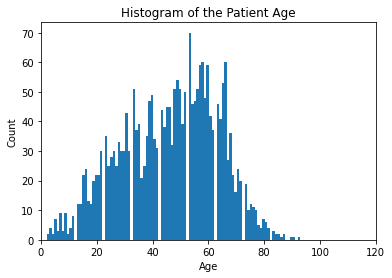

In [30]:
plt.hist(train_data['Patient Age'],bins=100);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

In [31]:
max(train_data['Patient Age'])

93

In [32]:
np.unique(train_data['Patient Age'])

array([ 2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
       19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35,
       36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52,
       53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69,
       70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 90, 91, 93])

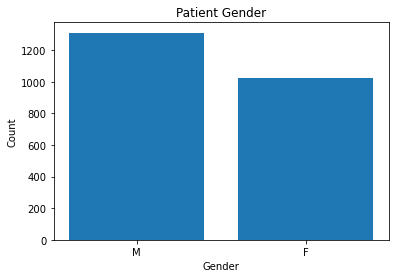

In [33]:
Gender=train_data['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

In [34]:
val_data['Patient ID'] 

276         61
279         61
901        218
902        218
1716       459
         ...  
84507    20799
12085     3149
20364     5448
89853    22312
98799    26122
Name: Patient ID, Length: 526, dtype: int64

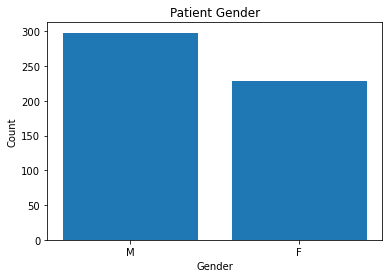

In [35]:
Gender=val_data['Patient Gender'].value_counts()
plt.bar(Gender.index, Gender);
plt.title('Patient Gender')
plt.xlabel('Gender')
plt.ylabel('Count');

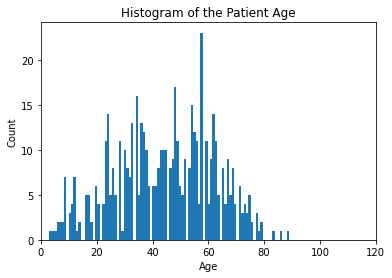

In [36]:
plt.hist(val_data['Patient Age'],bins=100);
plt.xlim(0,120);
plt.title('Histogram of the Patient Age')
plt.xlabel('Age')
plt.ylabel('Count');

In [37]:
# train_data.query('Pneumonia=="pneumonia"')['Pneumonia'].count()/len(train_data)

In [38]:
# val_data.query('Pneumonia=="pneumonia"')['Pneumonia'].count()/len(val_data)


In [39]:
train_data['Pneumonia']

48          pneumonia
126         pneumonia
253         pneumonia
590         pneumonia
614         pneumonia
             ...     
74838    no_pneumonia
95886    no_pneumonia
59515    no_pneumonia
51676    no_pneumonia
85083    no_pneumonia
Name: Pneumonia, Length: 2334, dtype: object

# Now we can begin our model-building & training

#### First suggestion: perform some image augmentation on your data

In [40]:
def my_image_augmentation():
    
    ## recommendation here to implement a package like Keras' ImageDataGenerator
    ## with some of the built-in augmentations 
    
    ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
    ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
    ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
    ## built into something like a Keras package
    
    # Todo
    train_idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = False, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20,
                              shear_range = 0.1,
                              zoom_range=0.3)
    
    val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
    return train_idg, val_idg



def make_train_gen(train_idg,train_df):
    
    ## Create the actual generators using the output of my_image_augmentation for your training data
    ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
    train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia',
                                         class_mode = 'binary',
                                         target_size = (224, 224), 
                                         batch_size = 64)
     # Todo

    return train_gen


def make_val_gen(val_idg,val_df):
    
    val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
                                             directory=None, 
                                             x_col = 'path',
                                             y_col = 'Pneumonia',
                                             class_mode = 'binary',
                                             target_size = (224, 224), 
                                             batch_size = 64) 
    
    # Todo
    return val_gen


In [41]:
# def image_augmentation():
    
#     ## recommendation here to implement a package like Keras' ImageDataGenerator
#     ## with some of the built-in augmentations 
    
#     ## keep an eye out for types of augmentation that are or are not appropriate for medical imaging data
#     ## Also keep in mind what sort of augmentation is or is not appropriate for testing vs validation data
    
#     ## STAND-OUT SUGGESTION: implement some of your own custom augmentation that's *not*
#     ## built into something like a Keras package
    
#     # Todo
#     train_idg = ImageDataGenerator(rescale=1. / 255.0,
#                               horizontal_flip = True, 
#                               vertical_flip = False, 
#                               height_shift_range= 0.1, 
#                               width_shift_range=0.1, 
#                               rotation_range=20,
#                               shear_range = 0.1,
#                               zoom_range=0.3,
#                               validation_split=0.2)
    
#     val_idg = ImageDataGenerator(rescale=1. / 255.0)
    
#     return train_idg, val_idg




# def make_train_gen(train_idg,train_df):
    
#     ## Create the actual generators using the output of my_image_augmentation for your training data
#     ## Suggestion here to use the flow_from_dataframe library, e.g.:
    
#     train_gen = my_train_idg.flow_from_dataframe(dataframe=train_df, 
#                                          directory=train_data_dir, 
#                                          x_col = 'path',
#                                          y_col = 'Pneumonia',
#                                          class_mode = 'binary',
#                                          target_size = (224, 224), 
#                                          batch_size = 64)
#      # Todo

#     return train_gen


# def make_val_gen(val_idg,val_df):
    
#     val_gen = my_val_idg.flow_from_dataframe(dataframe = val_data, 
#                                              directory=train_data_dir, 
#                                              x_col = 'path',
#                                              y_col = 'Pneumonia',
#                                              class_mode = 'binary',
#                                              target_size = (224, 224), 
#                                              batch_size = 64) 
    
#     # Todo
#     return val_gen



# model.fit_generator(
#     train_generator,
#     steps_per_epoch = train_generator.samples // batch_size,
#     validation_data = validation_generator, 
#     validation_steps = validation_generator.samples // batch_size,
#     epochs = nb_epochs)

In [43]:
my_train_idg,my_val_idg=my_image_augmentation()
val_gen=make_val_gen(my_val_idg,val_data)
valX, valY = val_gen.next()

Found 526 validated image filenames belonging to 2 classes.


In [44]:
train_gen=make_train_gen(my_train_idg,train_data)

Found 2334 validated image filenames belonging to 2 classes.


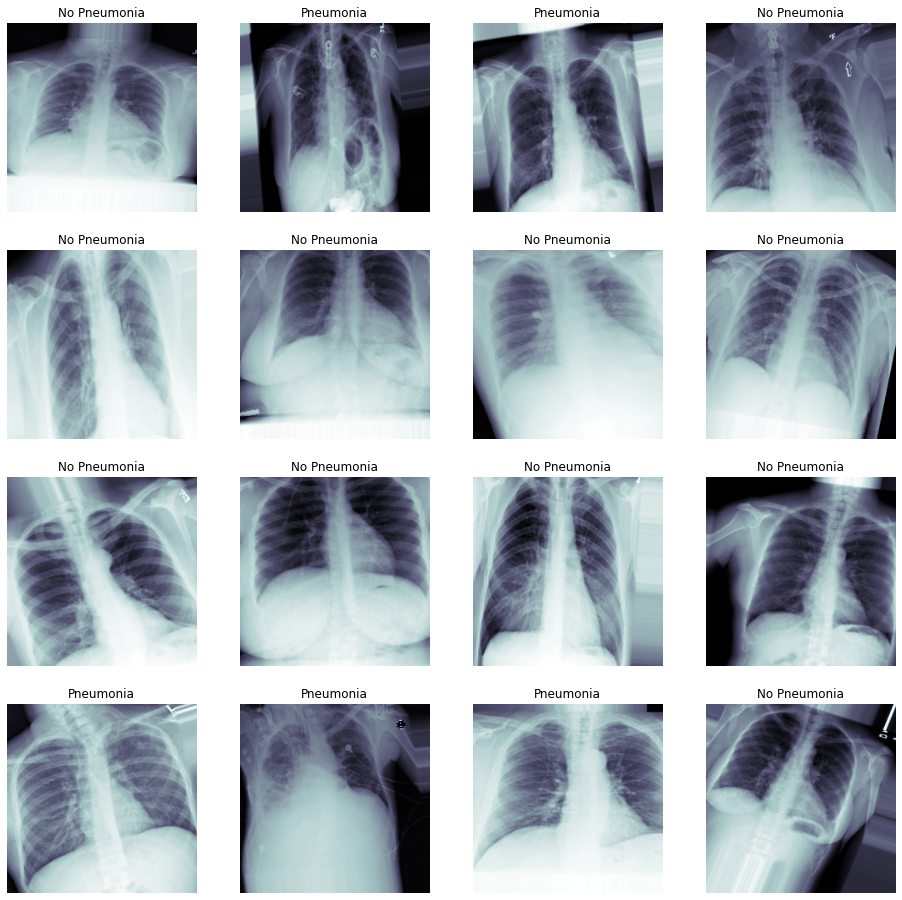

In [41]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

In [48]:
# valX[0].shape

## Build your model: 

Recommendation here to use a pre-trained network downloaded from Keras for fine-tuning

In [42]:
# As in solution for exercise
model = VGG16(include_top=True, weights='imagenet')
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)
for layer in vgg_model.layers[0:17]:
    layer.trainable = False
new_model = Sequential()
new_model.add(vgg_model)
new_model.add(Flatten())
new_model.add(Dropout(0.5))
new_model.add(Dense(1024, activation='relu'))
new_model.add(Dropout(0.5))

new_model.add(Dense(512, activation='relu'))
new_model.add(Dropout(0.5))

new_model.add(Dense(256, activation='relu'))
new_model.add(Dense(1, activation='sigmoid'))

553467904/553467096 [==============================] - 5s 0us/step


In [51]:
# import numpy as np
# import math

# # labels_dict : {ind_label: count_label}
# # mu : parameter to tune 

# def create_class_weight(labels_dict,mu=0.15):
#     total = np.sum(list(labels_dict.values()))
#     keys = labels_dict.keys()
#     class_weight = dict()
    
#     for key in keys:
#         score = math.log(mu*total/float(labels_dict[key]))
#         class_weight[key] = score if score > 1.0 else 1.0
    
#     return class_weight

# # random labels_dict
# labels_dict = {0: 112104, 1: 1430}

# class_weight = create_class_weight(labels_dict)

In [45]:
class_weights = {0: 0.12, 1: 0.98}

In [44]:
# optimizer = Adam(lr=1e-4)
# loss = 'binary_crossentropy'
# metrics = ['binary_accuracy']

In [ ]:
# import numpy as np
# from sklearn.utils import class_weight


# # Calculate the weights for each class so that we can balance the data
# weights = class_weight.compute_class_weight('balanced',
#                                             np.unique(y_train),
#                                             y_train)

# # Add the class weights to the training                                         
# model.fit(x_train, y_train, epochs=10, batch_size=32, class_weight=weights)

In [43]:
optimizer = Adam(lr=1e-4)
loss =  'binary_crossentropy'
metrics = ['binary_accuracy']

In [44]:
new_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [46]:
history = new_model.fit_generator(train_gen, 
                                  validation_data = val_gen, 
                                  epochs = 10,
                                 class_weight=class_weights)

Epoch 1/10
37/37 [==============================] - 73s 2s/step - loss: 0.2165 - binary_accuracy: 0.4979 - val_loss: 0.7303 - val_binary_accuracy: 0.5000
Epoch 2/10
37/37 [==============================] - 60s 2s/step - loss: 0.1989 - binary_accuracy: 0.4996 - val_loss: 0.9441 - val_binary_accuracy: 0.5000
Epoch 3/10
37/37 [==============================] - 61s 2s/step - loss: 0.1958 - binary_accuracy: 0.5000 - val_loss: 0.7144 - val_binary_accuracy: 0.5000
Epoch 4/10
37/37 [==============================] - 61s 2s/step - loss: 0.1940 - binary_accuracy: 0.5000 - val_loss: 0.8955 - val_binary_accuracy: 0.5000
Epoch 5/10
37/37 [==============================] - 62s 2s/step - loss: 0.1906 - binary_accuracy: 0.5000 - val_loss: 0.5651 - val_binary_accuracy: 0.5000
Epoch 6/10
37/37 [==============================] - 61s 2s/step - loss: 0.1908 - binary_accuracy: 0.5000 - val_loss: 0.9711 - val_binary_accuracy: 0.5000
Epoch 7/10
37/37 [==============================] - 61s 2s/step - loss: 0.18

In [47]:
def plot_history(history):
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

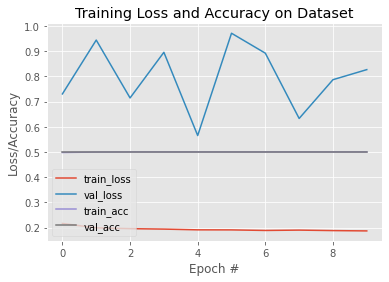

In [48]:
plot_history(history)

In [45]:
def load_pretrained_model():
    
    
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs = model.input, outputs = transfer_layer.output)
    
    return vgg_model



In [46]:
vgg_model=load_pretrained_model()
vgg_model.summary()

553467904/553467096 [==============================] - 5s 0us/step
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
__________________________________________________________

In [47]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=1e-5)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy']
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [48]:
my_model=build_my_model(vgg_model)

In [49]:
## Below is some helper code that will allow you to add checkpoints to your model,
## This will save the 'best' version of your model by comparing it to previous epochs of training

## Note that you need to choose which metric to monitor for your model's 'best' performance if using this code. 
## The 'patience' parameter is set to 10, meaning that your model will train for ten epochs without seeing
## improvement before quitting

# Todo

weight_path="my_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

early = EarlyStopping(monitor= 'val_loss', 
                      mode= 'min', 
                      patience=7)

callbacks_list = [checkpoint, early]


In [50]:
class_weights = {0: 0.12, 1: 0.98}

### Start training! 

In [53]:
## train your model

# Todo

history = my_model.fit_generator(train_gen, class_weight=class_weights,
                          validation_data = val_gen, 
                          epochs = 15, 
                          callbacks = callbacks_list)

Epoch 1/15
37/37 [==============================] - 76s 2s/step - loss: 0.2157 - binary_accuracy: 0.4987 - val_loss: 1.5734 - val_binary_accuracy: 0.5000

Epoch 00001: val_loss improved from inf to 1.57339, saving model to my_model.best.hdf5
Epoch 2/15
37/37 [==============================] - 59s 2s/step - loss: 0.1911 - binary_accuracy: 0.5000 - val_loss: 0.8729 - val_binary_accuracy: 0.5000

Epoch 00002: val_loss improved from 1.57339 to 0.87288, saving model to my_model.best.hdf5
Epoch 3/15
37/37 [==============================] - 60s 2s/step - loss: 0.1900 - binary_accuracy: 0.5000 - val_loss: 1.2087 - val_binary_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.87288
Epoch 4/15
37/37 [==============================] - 60s 2s/step - loss: 0.1878 - binary_accuracy: 0.5000 - val_loss: 0.5794 - val_binary_accuracy: 0.5000

Epoch 00004: val_loss improved from 0.87288 to 0.57945, saving model to my_model.best.hdf5
Epoch 5/15
37/37 [==============================] - 60s 2s/s

##### After training for some time, look at the performance of your model by plotting some performance statistics:

Note, these figures will come in handy for your FDA documentation later in the project

In [54]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

64/64 [==============================] - 4s 59ms/step


In [55]:
def plot_auc(t_y, p_y):
    
    ## Hint: can use scikit-learn's built in functions here like roc_curve
    
    # Todo
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    fpr, tpr, thresholds = roc_curve(t_y, p_y)
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % ('Pneumonia', auc(fpr, tpr)))
    c_ax.legend()
    c_ax.set_xlabel('False Positive Rate')
    c_ax.set_ylabel('True Positive Rate')
    
    return

## what other performance statistics do you want to include here besides AUC? 
def plot_pr(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    c_ax.plot(precision, recall, label = '%s (AP Score:%0.2f)'  % ('Pneumonia', average_precision_score(t_y,p_y)))
    c_ax.legend()
    c_ax.set_xlabel('Recall')
    c_ax.set_ylabel('Precision')
    
def plot_f1t(t_y, p_y):
    fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
    precision, recall, thresholds = precision_recall_curve(t_y, p_y)
    f1=2*(precision*recall)/(precision+recall)
    c_ax.plot(f1[0:len(thresholds)], thresholds, label = 'f1_score vs threshold')
    c_ax.legend()
    c_ax.set_xlabel('thresholds')
    c_ax.set_ylabel('f1_score')

def  calc_f1(prec,recall):

    return 2*(prec*recall)/(prec+recall)
    
#Also consider plotting the history of your model training:

def plot_history(history):
    
    N = len(history.history["loss"])
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), history.history["binary_accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), history.history["val_binary_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy on Dataset")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="lower left")

# def ... 
# Todo

# def ...
# Todo
    
#Also consider plotting the history of your model training:

# def plot_history(history):
    
#     # Todo
#     return

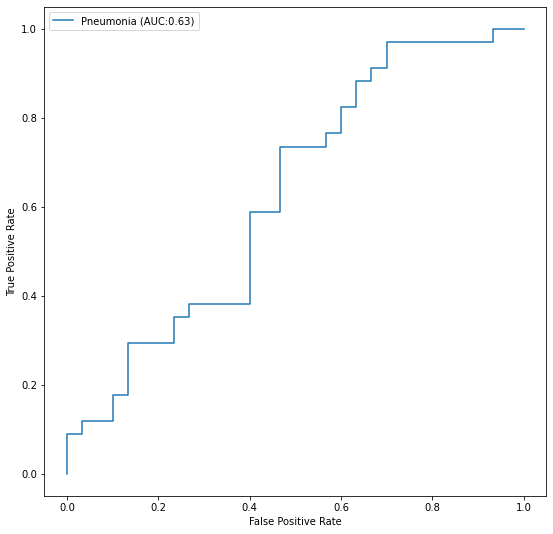

In [56]:
## plot figures
plot_auc(valY, pred_Y)
# Todo

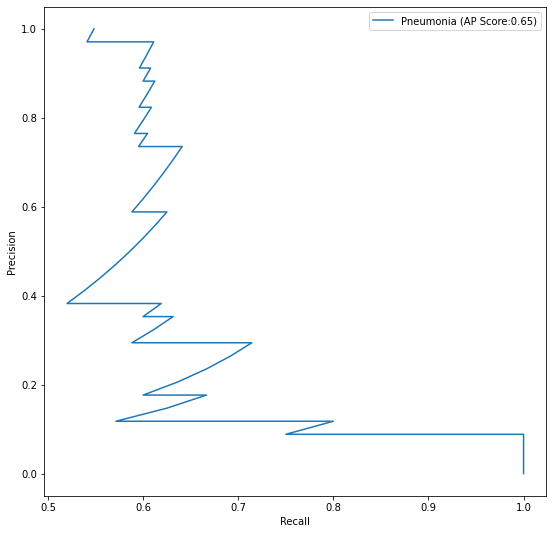

In [57]:
plot_pr(valY, pred_Y)

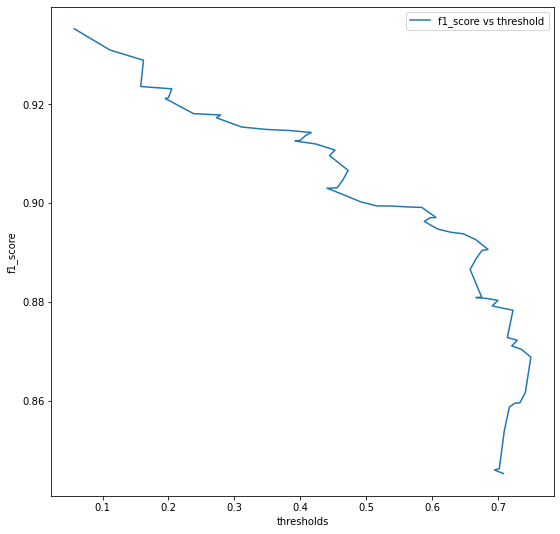

In [58]:
plot_f1t(valY, pred_Y)

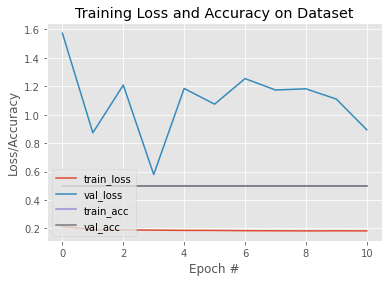

In [59]:
plot_history(history)

Once you feel you are done training, you'll need to decide the proper classification threshold that optimizes your model's performance for a given metric (e.g. accuracy, F1, precision, etc.  You decide) 

In [60]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
# Look at the threshold where recall is 0.0
recall_value = 0.7
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))
# Todo

Precision is: 0.631578947368421
Recall is: 0.7058823529411765
Threshold is: 0.89253175
F1 Score is: 0.6666666666666667


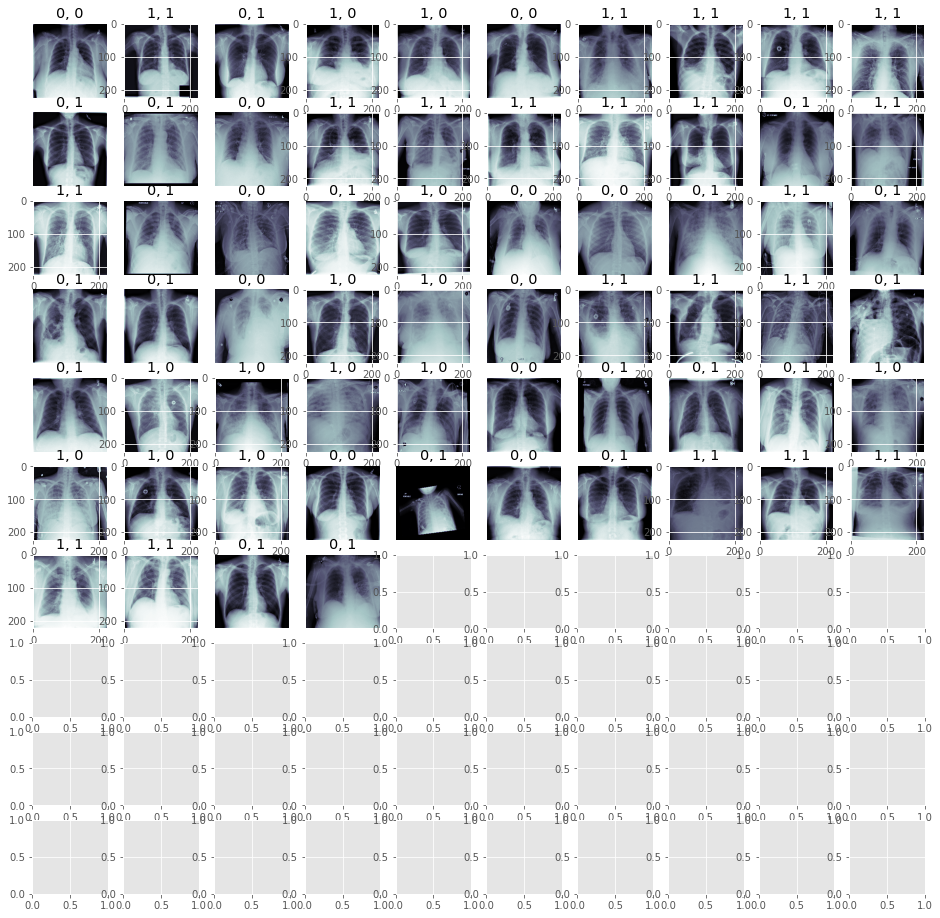

In [61]:
## Let's look at some examples of true vs. predicted with our best model: 

# Todo

fig, m_axs = plt.subplots(10, 10, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX[0:100], valY[0:100], m_axs.flatten()):
        c_ax.imshow(c_x[:,:,0], cmap = 'bone')
        if c_y == 1: 
            if pred_Y[i] > thresholds[idx]:
                c_ax.set_title('1, 1')
            else:
                c_ax.set_title('1, 0')
        else:
            if pred_Y[i] > thresholds[idx]: 
                c_ax.set_title('0, 1')
            else:
                c_ax.set_title('0, 0')
            c_ax.axis('off')
            i=i+1

    


In [62]:
## Just save model architecture to a .json:

model_json = my_model.to_json()
with open("my_model.json", "w") as json_file:
    json_file.write(model_json)

In [63]:
from keras import backend as K

def f1(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [64]:
def build_my_model(vgg_model):
    
    # my_model = Sequential()
    # ....add your pre-trained model, and then whatever additional layers you think you might
    # want for fine-tuning (Flatteen, Dense, Dropout, etc.)
    
    # if you want to compile your model within this function, consider which layers of your pre-trained model, 
    # you want to freeze before you compile 
    
    # also make sure you set your optimizer, loss function, and metrics to monitor
    
    # Todo
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    my_model = Sequential()

    # Add the convolutional part of the VGG16 model from above.
    my_model.add(vgg_model)

    # Flatten the output of the VGG16 model because it is from a
    # convolutional layer.
    my_model.add(Flatten())
    my_model.add(Dropout(0.5))
    my_model.add(Dense(1024, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(512, activation='relu'))
    my_model.add(Dropout(0.5))
    my_model.add(Dense(256, activation='relu'))

    # Add a dense (aka. fully-connected) layer.
    # This is for combining features that the VGG16 model has
    # recognized in the image.
    my_model.add(Dense(1, activation='sigmoid'))
    optimizer = Adam(lr=1e-7)
    loss = 'binary_crossentropy'
    metrics = ['binary_accuracy', f1]
 
    my_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    
    
    return my_model



## STAND-OUT Suggestion: choose another output layer besides just the last classification layer of your modele
## to output class activation maps to aid in clinical interpretation of your model's results

In [65]:
my_model=build_my_model(vgg_model)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint


weight_path="my_model.best2.hdf5".format('xray_class')



check_point = ModelCheckpoint(weight_path, monitor="val_binary_accuracy", mode="max",
                              verbose=True, save_best_only=True)
early_stop = EarlyStopping(monitor="val_binary_accuracy", mode="max", patience=8,verbose=True)

history1 = my_model.fit_generator(train_gen, 
                          validation_data = (valX, valY), epochs=30,
                    steps_per_epoch=100,
                    verbose=True,
                    callbacks=[early_stop,check_point])


Epoch 1/30
 15/100 [===>..........................] - ETA: 2:22 - loss: 1.0129 - binary_accuracy: 0.5031 - f1: 0.6295

In [ ]:
my_model.load_weights(weight_path)
pred_Y = my_model.predict(valX, batch_size = 32, verbose = True)

In [ ]:
plot_auc(valY, pred_Y)

In [ ]:
plot_history(history1)

In [ ]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

precision, recall, thresholds = precision_recall_curve(valY, pred_Y)
# Look at the threshold where recall is 0.0
recall_value = 0.7
idx = (np.abs(recall - recall_value)).argmin() 
print('Precision is: '+ str(precision[idx]))
print('Recall is: '+ str(recall[idx]))
print('Threshold is: '+ str(thresholds[idx]))
print('F1 Score is: ' + str(calc_f1(precision[idx],recall[idx])))
# Todo

In [ ]:
# Third model for AUC enhancement

In [ ]:
model_json = my_model.to_json()
with open("my_model1.json", "w") as json_file:
    json_file.write(model_json)

In [ ]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [ ]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = VGG16(include_top=True, weights='imagenet')
    transfer_layer = model.get_layer('block5_pool')
    vgg_model = Model(inputs=model.input, outputs=transfer_layer.output)
    for layer in vgg_model.layers[0:17]:
        layer.trainable = False
    new_model = Sequential()
    new_model.add(vgg_model)
    new_model.add(Flatten())
    new_model.add(Dropout(0.5))
    new_model.add(Dense(1024, activation='relu'))
    new_model.add(Dropout(0.5))

    new_model.add(Dense(512, activation='relu'))
    new_model.add(Dropout(0.5))

    new_model.add(Dense(256, activation='relu'))
    new_model.add(Dense(1, activation='sigmoid'))
    
    
    
    
    model.compile(
      optimizer=keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)
    return model

In [ ]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [ ]:
model = make_model()
model.summary()

In [ ]:
weight_path="my_model.best3.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, 
                             monitor= 'val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode= 'min', 
                             save_weights_only = True)

callbacks_list = [checkpoint, early_stopping]

In [ ]:
model = make_model()
history = model.fit_generator(train_gen, 
                          validation_data = (valX, valY), 
                          epochs=EPOCHS,
                          callbacks = callbacks_list)

In [ ]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))